# Thruster firings are removed from the results

1. Find all times for thruster firings, i.e. 524288,524288\*2
2. Check for CR 8192 flags
3. Define final cleaned isflare sequence
4. Average all test LCs

## 1. Find and remove thruster firings

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import time
import os
from glob import glob
import math
import numpy as np
import pyke as pk
import pandas as pd
import k2flix
import matplotlib.pyplot as plt

#-------------------------------------------------------------------------
#Set parameters here:
cluster = 'M67'
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}'.format(cluster))
oid_list = pd.read_csv('{}_full.txt'.format(cluster),names=['EPIC'])
oid_list = oid_list.EPIC.tolist()
test = 'run_08'
o = 211412571 #M67
#o = 211954033 #M44
#--------------------------------------------------------------------------

def find_nearest(array,value):

    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1], idx-1
    else:
        return array[idx], idx


def tpf_time_match(flux, tpf):

    flags = []
    timed = []
    quality = tpf.hdulist[1].data['QUALITY']
    print(time.clock())
    for id_,row in flux.iterrows():

        t, idx_ = find_nearest(tpf.bkjd(), row.time)
        timed.append(t)
        flags.append(quality[idx_])

    flux['tpf_flags'] = flags
    flux['tpf_time'] = timed
    return flux



def wrap_tpf_time_match(oid_list,test):
    tpfs, flux, flares = dict(), dict(), dict()
    for oid in oid_list:
        tpfs[oid] = k2flix.TargetPixelFile('ktwo{}-c05_lpd-targ.fits.gz'.format(oid))
        
        flares[oid] = pd.read_csv('results/{}/{}_flares.csv'.format(test,oid),
                                 usecols=['istart','istop'],
                                 dtype=int)
        if glob('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid)) == []:
            flux[oid] = pd.read_csv('results/{}/{}_flux.csv'.format(test,oid),usecols=['flux_gap','time','flux_model'])
            flux[oid] = tpf_time_match(flux[oid],tpfs[oid])
            flux[oid].to_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid))
        else:
            flux[oid] = pd.read_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid),
                                usecols=['flux_gap','time','flux_model','tpf_time','tpf_flags'])
    return flux, flares, tpfs
                                          
def edges_to_bool(start_stop,flux):
    
    rangeflare = []
    for i,row in start_stop.iterrows():
            rangeflare.append(list(range(row.istart,row.istop+1)))
    isflare = np.zeros_like(flux.time.tolist())
    rangeflare = [item for sublist in rangeflare for item in sublist]

    np.put(isflare,rangeflare,np.ones_like(rangeflare))

    return isflare  



def remove_thruster_firings(tpfs, flux, flares, oid):
    remove = []
    for i in range(len(tpfs[oid].hdulist[1].data['FLUX'])): 
        if tpfs[oid].hdulist[1].data['QUALITY'][i] > 524288:#flag values are summed up!
            remove.append(tpfs[oid].bkjd(i))
            try:
                remove.append(tpfs[oid].bkjd(i-1))
            except IndexError:
                print('IndexError -1')
                pass
            try:
                remove.append(tpfs[oid].bkjd(i+1))
            except IndexError:
                print('IndexError +1')
                pass

    remove_id = [flux[oid].index.values[np.round(flux[oid].time,6) == np.round(remove_time,6)][0] for remove_time in sorted(list(set(remove)))]
    isflare = edges_to_bool(flares[oid],flux[oid])
    new_isflare = np.array(isflare)
    new_flags = np.array(flux[oid].tpf_flags)
    for id_ in remove_id:
        if isflare[id_] == 1.:
            for j, row in flares[oid].iterrows():
                if (row.istart <= id_) & (row.istop+1 >=id_):
                    new_isflare[row.istart:row.istop+1] = 0
                    new_flags[row.istart:row.istop+1] = 0

    flux[oid]['isflare'] = isflare
    flux[oid]['new_isflare'] = new_isflare
    flux[oid]['new_tpf_flags'] = new_flags
    return


def remove_systematics(flux,test,oid):
    s = pd.read_csv('results/{}/systematics.csv'.format(test),names=['systematics']).systematics.tolist()
    flux[oid]['tpf_flags_wo_systematics'] = np.array(flux[oid].tpf_flags)
    flux[oid]['isflare_wo_systematics'] = np.array(flux[oid]['isflare'])
    flux[oid]['tpf_flags_wo_systematics'].iloc[s]= 0
    flux[oid]['isflare_wo_systematics'].iloc[s]= 0
    return

def flag_df(flux):
    index = [1,8192,524288]
    columns = ['>',
               '>_after_thruster_removal',
               '>_after_systematics_removal',
               '>_left_overall',
               '>_coinciding_with_flare_candidates',
               '>_coinciding_with_clean_flare_candidates',
              ]
    flags = pd.DataFrame(index=index, columns=columns)
    for flag in index:
        flags[columns[0]].loc[flag] = flux[flux.tpf_flags >= flag].shape[0]
        flags[columns[1]].loc[flag] = flux[flux.new_tpf_flags >= flag].shape[0]
        flags[columns[2]].loc[flag] = flux[flux.tpf_flags_wo_systematics >= flag].shape[0]
        flags[columns[3]].loc[flag] = flux[(flux.tpf_flags_wo_systematics >= flag) & (flux.new_tpf_flags >= flag)].shape[0]
        flags[columns[4]].loc[flag] = flux[(flux.isflare == True) & (flux.tpf_flags >= flag)].shape[0]
        flags[columns[5]].loc[flag] = flux[(flux.isflare_no_sys_no_thruster == True) & (flux.tpf_flags >= flag)].shape[0]
    return flags.T




flux, flares, tpfs = wrap_tpf_time_match(oid_list, test)

3.544504
4.281158
5.072284
5.790203
6.618582
7.366036
8.097033
8.869039
9.665376
10.398128
11.227554
12.0543
12.838964
13.632925
14.561043
15.341238
16.085103
16.880463
17.672519
18.471675
19.232826
19.967337
20.728875
21.469875
22.215533
23.01202
23.75051
24.514114
25.276304
26.033224
26.797223
27.620249
28.401247
29.159494
30.101391
30.867821
31.606727
32.388458
33.133994
33.873413
34.630414
35.375169
36.10498
36.876563
37.621747
38.446091
39.187303
39.951462
40.691164
41.430853
42.169115
42.903823
43.659745
44.494169
45.269292
46.010184
46.758187
47.481647
48.205765
48.949168
49.70044
50.450347
51.280428
52.025697
52.781754
53.517184
54.292561
55.063354
55.805065
56.5338
57.356938
58.112403
58.886297
59.691865
60.449959


In [2]:
flares[o].tail()

,istart,istop
29,3296,3300
30,3314,3318
31,3404,3407
32,3491,3494
33,3573,3575


In [3]:
for oid in oid_list:
    remove_thruster_firings(tpfs, flux, flares, oid)
    remove_systematics(flux, test, oid)

In [4]:
flux[o].iloc[1518:1525]

,flux_gap,flux_model,time,tpf_flags,tpf_time,isflare,new_isflare,new_tpf_flags,tpf_flags_wo_systematics,isflare_wo_systematics
1518,2770.972716,2771.751789,2337.626687,0,2337.626687,0.0,0.0,0,0,0.0
1519,2773.394914,2771.859266,2337.647119,0,2337.647119,0.0,0.0,0,0,0.0
1520,2775.455254,2772.124861,2337.667551,0,2337.667551,0.0,0.0,0,0,0.0
1521,2779.131991,2772.549457,2337.687982,1048576,2337.687982,0.0,0.0,1048576,0,0.0
1522,2771.125793,2773.101271,2337.708414,0,2337.708414,0.0,0.0,0,0,0.0
1523,2772.048708,2773.746554,2337.728846,0,2337.728846,0.0,0.0,0,0,0.0
1524,2769.636817,2774.451567,2337.749277,0,2337.749277,0.0,0.0,0,0,0.0


## 2. Check for CR flag

In [5]:
flux[o][(flux[o].tpf_flags_wo_systematics >= 8192) & (flux[o].new_tpf_flags >= 8192)  & (flux[o].isflare >0)]

,flux_gap,flux_model,time,tpf_flags,tpf_time,isflare,new_isflare,new_tpf_flags,tpf_flags_wo_systematics,isflare_wo_systematics
260,2849.852771,2769.365077,2311.923381,10240,2311.923381,1.0,1.0,10240,10240,1.0
512,2844.750296,2770.634496,2317.072257,10240,2317.072257,1.0,1.0,10240,10240,1.0
536,2807.841240,2769.365795,2317.562625,8192,2317.562625,1.0,1.0,8192,8192,1.0
896,2816.815871,2781.647664,2324.918118,8192,2324.918118,1.0,1.0,8192,8192,1.0
2345,2793.822423,2783.941758,2354.523677,8192,2354.523677,1.0,1.0,8192,8192,1.0
3051,2808.294634,2776.498618,2368.948434,8192,2368.948434,1.0,1.0,8192,8192,1.0
3314,2858.729018,2773.854802,2374.321979,10240,2374.321979,1.0,1.0,10240,10240,1.0


## 3. Create final isflare sequence

In [6]:
def bool_to_edges(isflare):
    
    c, start, stop = False, [], []
    isflare = list(isflare)
    for id_, bool_ in enumerate(isflare):
        if c == False and bool_ == True:
            start.append(id_)
            c = True
        elif c == True and bool_ == False:
            stop.append(id_-1)
            c = False
    start_stop = pd.DataFrame({'istart':start},dtype=int)#,'istop':stop})
    start_stop = start_stop.join(pd.Series(stop,name='istop',dtype=int))
    return start_stop   

for oid in oid_list:
    flux[oid]['isflare_no_sys_no_thruster'] = (flux[oid].new_isflare == 1.) & (flux[oid].isflare_wo_systematics == 1.)
    start_stop = bool_to_edges(flux[oid].isflare_no_sys_no_thruster)
    flares[oid] = flares[oid].join(start_stop,rsuffix='_no_sys_no_thruster')
    flux[oid].to_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid))
flares[o]

,istart,istop,istart_no_sys_no_thruster,istop_no_sys_no_thruster
0,260,266,260.0,266.0
1,405,407,512.0,514.0
2,429,434,536.0,539.0
3,512,514,896.0,899.0
4,536,539,970.0,971.0
5,788,791,1372.0,1382.0
6,837,839,1667.0,1673.0
7,896,899,1735.0,1741.0
8,966,971,1862.0,1864.0
9,1053,1055,1888.0,1890.0


## 4. Compile a table averageing over all test LCs

In [7]:
summary = dict()
for oid in oid_list:
    summary[oid] = flag_df(flux[oid]).stack()
sum_ = summary[oid_list[0]].to_frame(name=oid_list[0])
#print(sum_)
for oid in oid_list[1:]:
    sum_[oid] = summary[oid]

#sum_ = sum_/len(oid_list)

print(sum_.mean(axis=1))
print(sum_.std(axis=1))

>                                         1         362.640000
                                          8192      355.600000
                                          524288    201.000000
>_after_thruster_removal                  1         343.680000
                                          8192      338.493333
                                          524288    190.946667
>_after_systematics_removal               1         291.226667
                                          8192      285.746667
                                          524288    156.000000
>_left_overall                            1         282.600000
                                          8192      278.453333
                                          524288    151.946667
>_coinciding_with_flare_candidates        1          21.826667
                                          8192       18.973333
                                          524288     10.053333
>_coinciding_with_clean_flare_candidates  1           2

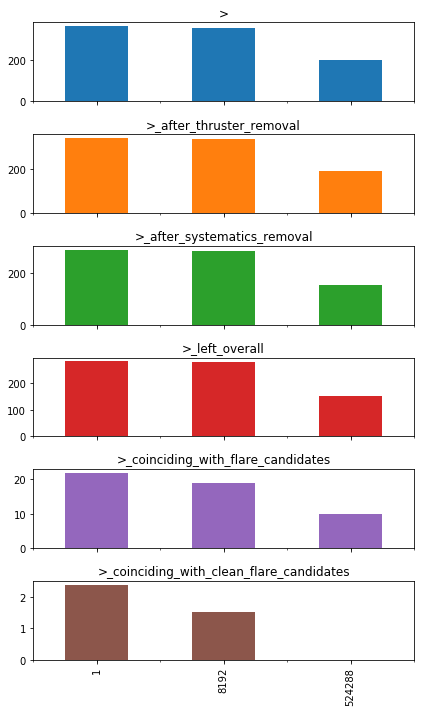

In [8]:

p = sum_.mean(axis=1).unstack(level=0).plot(kind='bar', subplots=True,figsize=(6,10),legend=False)
plt.tight_layout()
#plt.show()

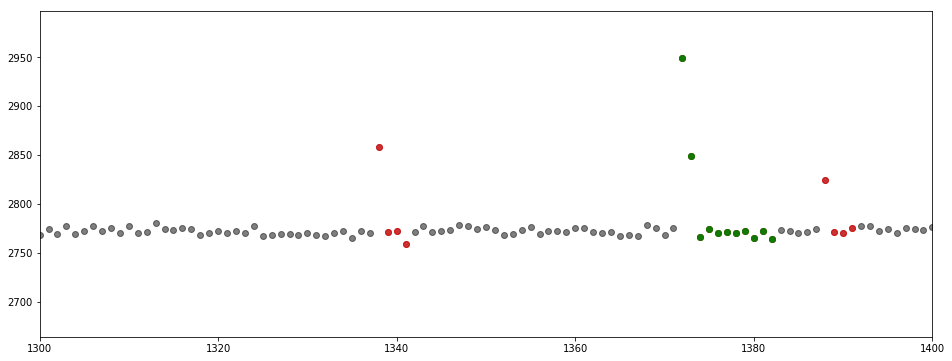

In [9]:
oid = o
plt.figure(figsize=(16,6))
plt.scatter(flux[oid].index.values,
            flux[oid].flux_gap,
            color='black',
            alpha=0.5)
for id_, row in flares[oid].iterrows():
    plt.scatter(flux[oid].index.values[int(row.istart):int(row.istop+1)],
                flux[oid].flux_gap.iloc[int(row.istart):int(row.istop+1)],
                color='red',
                alpha=0.6)
new_flares = flares[oid][['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
new_flares.dropna(inplace=True)
for id_, row in new_flares.iterrows():
    plt.scatter(flux[oid].index.values[int(row.istart_no_sys_no_thruster):int(row.istop_no_sys_no_thruster+1)],
                flux[oid].flux_gap.iloc[int(row.istart_no_sys_no_thruster):int(row.istop_no_sys_no_thruster+1)],
                color='green',
                alpha=0.9)   
plt.xlim(1300,1400)
plt.savefig('results/{}/plots/{}_example_LC.jpg'.format(test,o))

In [10]:
for oid in oid_list:
    flares[oid].to_csv('results/{}/{}_flares.csv'.format(test,oid))
    flux[oid].to_csv('results/{}/{}_flux.csv'.format(test,oid))